<a href="https://colab.research.google.com/github/chaitsugale/Style-Transfer-using-CycleGAN/blob/main/Style_Transfer_MR1_T1_T2_Cyclic_GAN_Capstone_Project_Chaitanya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Style Transfer Using Cyclic GAN Capstone Project

### By: Chaitanya Ugale

**Background** :

Misdiagnosis in the medical field is a very serious issue but it’s also uncomfortably common to occur. Imaging procedures in the medical field requires an expert radiologist’s opinion since interpreting them is not a simple binary process ( Normal or Abnormal). Even so, one radiologist may see something that another does not. This can lead to conflicting reports and make it difficult to effectively recommend treatment options to the patient.

One of the complicated tasks in medical imaging is to diagnose MRI(Magnetic Resonance Imaging). Sometimes to interpret the scan, the radiologist needs different variations of the imaging which can drastically enhance the accuracy of diagnosis by providing practitioners with a more comprehensive understanding.

But to have access to different imaging is difficult and expensive. With the help of deep learning, we can use style transfer to generate artificial MRI images of different contrast levels from existing MRI scans. This will help to provide a better diagnosis with the help of an additional image.

**Problem Statement :**

To build a Generative adversarial model(modified U-Net) which can generate artificial MRI images of different contrast levels from existing MRI scans.

### Importing Packages

In [1]:
# Importing warning package
import warnings
warnings.filterwarnings('ignore')

# Importing all the required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
import imageio
import glob
import os
import cv2
import pathlib

# importinf tensorflow libraries

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,Sequential,optimizers,metrics,Model
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization,Activation,Flatten,Conv2D,Conv2DTranspose
from keras.utils.vis_utils import plot_model

In [2]:
#loading the package for google drive

from google.colab import drive

#mounting content from google drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#unzipping the file

!unrar x "gdrive/MyDrive/MRI+T1_T2+Dataset.RAR" "/content/gdrive/MyDrive/"

#!unzip gdrive/MyDrive/MRI+T1_T2+Dataset -d '/content/gdrive/MyDrive/'


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from gdrive/MyDrive/MRI+T1_T2+Dataset.RAR


Would you like to replace the existing file /content/gdrive/MyDrive/Tr1/.DS_Store
  6148 bytes, modified on 2022-05-27 06:17
with a new one
  6148 bytes, modified on 2020-11-30 11:44

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit A

Extracting  /content/gdrive/MyDrive/Tr1/.DS_Store                          0%  OK 
Extracting  /content/gdrive/MyDrive/Tr1/TrainT1/Image #10.png              1%  OK 
Extracting  /content/gdrive/MyDrive/Tr1/TrainT1/Image #11.png              2%  OK 
Extracting  /content/gdrive/MyDrive/Tr1/TrainT1/Image #12.png              3%  OK 
Extracting  /content/gdrive/MyDrive/Tr1/TrainT1/Image #13.png              4%  OK 
Extracting  /content/gdrive/MyDrive/Tr1/TrainT1/Image #14.png              5%  OK 
Extracting  /content/gdrive/MyDrive/Tr1/TrainT1/Image #15.png              6%  OK 

Counts of File

In [4]:
#Defining the path of data

#for tr1
#tr1_data = pathlib.Path('/content/gdrive/MyDrive/Tr1/TrainT1')

#for tr2
#tr2_data = pathlib.Path('/content/gdrive/MyDrive/Tr2/TrainT2')

base_dir = pathlib.Path("/content/gdrive/My Drive")
os.chdir(base_dir)

tr1_data = pathlib.Path(str(base_dir) + "/Tr1/TrainT1")
tr2_data = pathlib.Path(str(base_dir) + "/Tr2/TrainT2")

print("Path for T1 data :\n", tr1_data)
print("Path for T2 data :\n", tr2_data)

Path for T1 data :
 /content/gdrive/My Drive/Tr1/TrainT1
Path for T2 data :
 /content/gdrive/My Drive/Tr2/TrainT2


In [5]:
!ls

 1517577920_PPG_ThinkEvil_Tshirt_SquareImage.png
 1517578044_Zakir-khan_Haq-se-single_JanhaviD.....png
 1520690500453_MonkeyCamActivity.java.gdoc
 20170226_142829.jpg
 20180112162229-1.jpg
 20180206114458-1.jpg
'abstract 2.pdf'
 ajax_tutorial.pdf
 android_tutorial.pdf
'angular (1).gdoc'
 angular.gdoc
 anime.jpg
'APIGEE - Analytics Services (1).gdoc'
'APIGEE - Analytics Services (2).gdoc'
'APIGEE - Analytics Services.gdoc'
'AWS (1).gdoc'
'Azure Essentials Q&A (1).gdoc'
'Azure Essentials Q&A.gdoc'
'Azure Virtual mc (1).gdoc'
'Azure Virtual mc (2).gdoc'
'Azure Virtual mc.gdoc'
 bgc.pdf
'bharti aadhar.pdf'
'bharti sbi.pdf'
'Block Chain (2) (1).gdoc'
'Block Chain (2) (2).gdoc'
'Block Chain (2) (3).gdoc'
'Block Chain (2).gdoc'
 bonafide_1458508_1578333021539.pdf
 carryled.asm
 CCCCC.pdf
'cd (1).gdoc'
 cd.gdoc
 chaitanya1.pdf
 chaitanya2.pdf
'chaitanya payment exam.pdf'
'Chaitanya Resume.docx'
'Chaitanya Resume.pdf'
'chaitanya rtes practical'
'Chaitanya seminar presentation.pptx'
'chaitanya S

## Step 1 : Data Understanding

In [6]:
# Checking the image count 

image_count_tr1 = len(list(tr1_data.glob('*.png')))

image_count_tr2 = len(list(tr2_data.glob('*.png')))

print('No. of image in TR1 : ',image_count_tr1)

print('No. of image in TR2 : ',image_count_tr2)

No. of image in TR1 :  43
No. of image in TR2 :  46


In [7]:
# sample to check the image size

mr1_sample = cv2.imread('/content/gdrive/MyDrive/Tr1/TrainT1/Image #34.png')

mr1_sample.shape

(217, 181, 3)

In [8]:
# The input shape for image should be (256, 256) so we are setting the image size

image_height = 217
image_width = 181

In [9]:
# setting up default batch size

mr1_batch_size = 32

### Loading Image

In [10]:
t1_image = image_dataset_from_directory(tr1_data,seed=123,shuffle = True,labels = None,image_size = (image_height,image_width),batch_size = mr1_batch_size )

Found 43 files belonging to 1 classes.


In [11]:
t2_image = image_dataset_from_directory(tr2_data,seed=123,shuffle = True,labels = None,image_size = (image_height,image_width),batch_size = mr1_batch_size )

Found 46 files belonging to 1 classes.


### Data Visualization

TR1 IMAGE


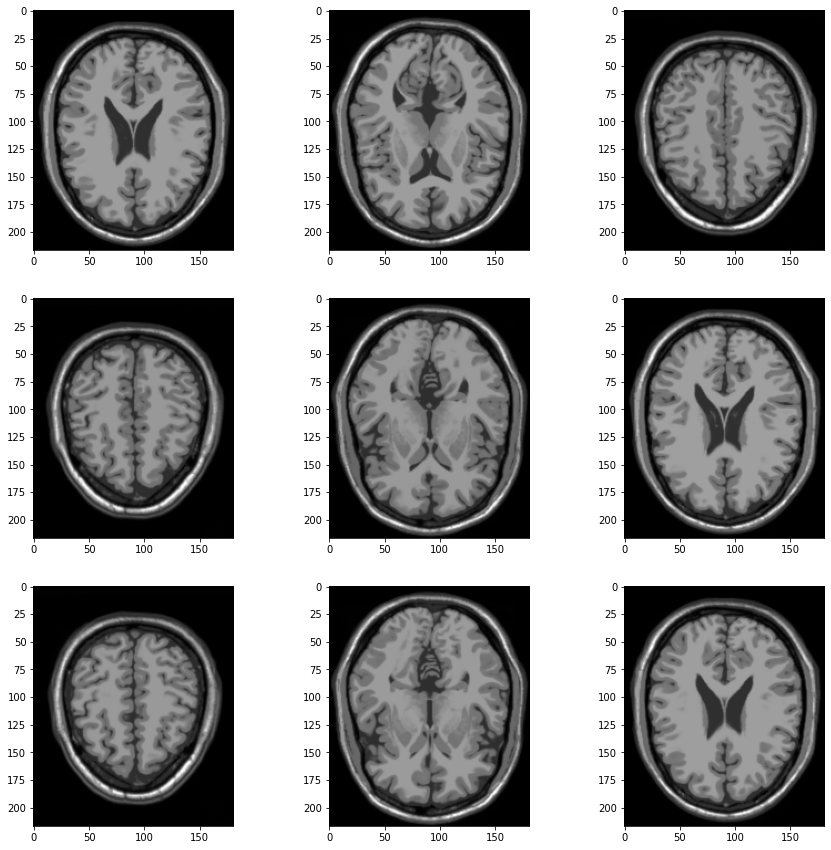

In [12]:
plt.figure(figsize=(15,15))
  
print("TR1 IMAGE")

for images in t1_image.take(2):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))

TR2 IMAGE


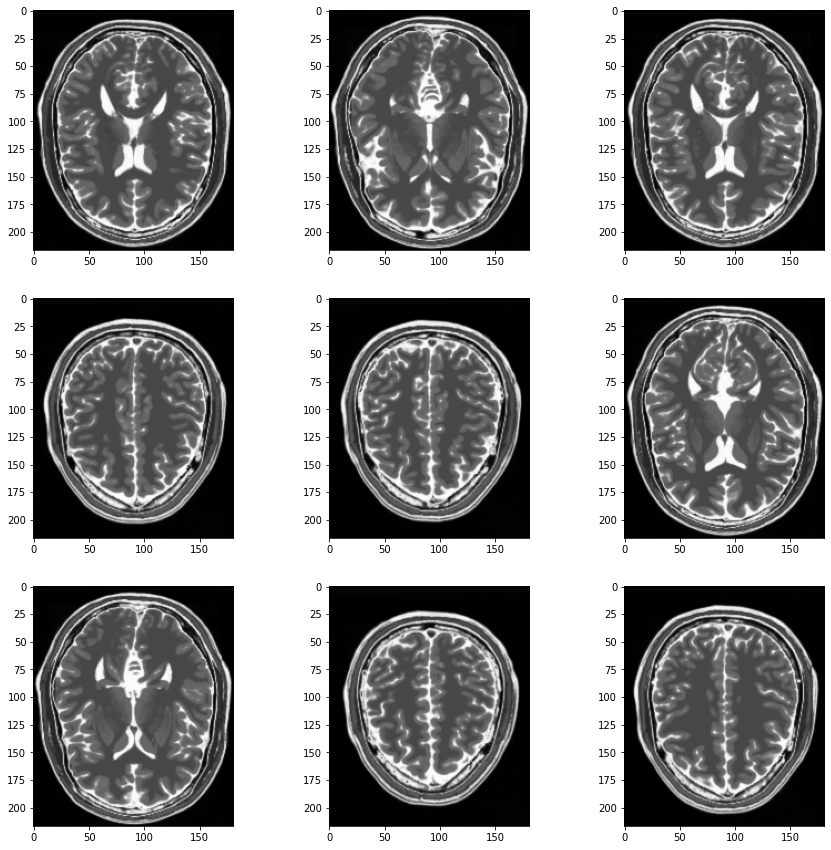

In [13]:
plt.figure(figsize=(15,15))
  
print("TR2 IMAGE")

for images_1 in t2_image.take(2):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images_1[i].numpy().astype('uint8'))

In [14]:
# checking the range of value of pixel making up the image in T1 data

image_batch_t1 = next(iter(t1_image))

first_image = image_batch_t1[0]

print('Pixel Value Range of T1 Image is from ',np.min(first_image),' to ',np.max(first_image))

Pixel Value Range of T1 Image is from  0.0  to  255.0


In [15]:
# checking the range of value of pixel making up the image in T2 data

image_batch_t2 = next(iter(t1_image))

first_image = image_batch_t2[0]

print('Pixel Value Range of T2 Image is from ',np.min(first_image),' to ',np.max(first_image))

Pixel Value Range of T2 Image is from  0.0  to  255.0


## Step 2 : Data Preprocessing




### A. Data Normalization

In [16]:
# Defining normalization layer

normalization_layer  =  layers.experimental.preprocessing.Rescaling(scale=1./127.5,offset = -1.0)

In [17]:
# Normalizing T1 Images

normalize_t1 = t1_image.map(lambda x: (normalization_layer(x)))

image_batch1 = next(iter(normalize_t1))

first_image = image_batch1[0]

print('After Normalization for T1 : ')

print('Minimum : ',np.min(first_image),' Maximum : ',np.max(first_image))

After Normalization for T1 : 
Minimum :  -1.0  Maximum :  1.0


In [18]:
# checking shape of batch

image_t1_batch = next(iter(normalize_t1))

image_t1_batch.shape

TensorShape([32, 217, 181, 3])

TR1 IMAGE


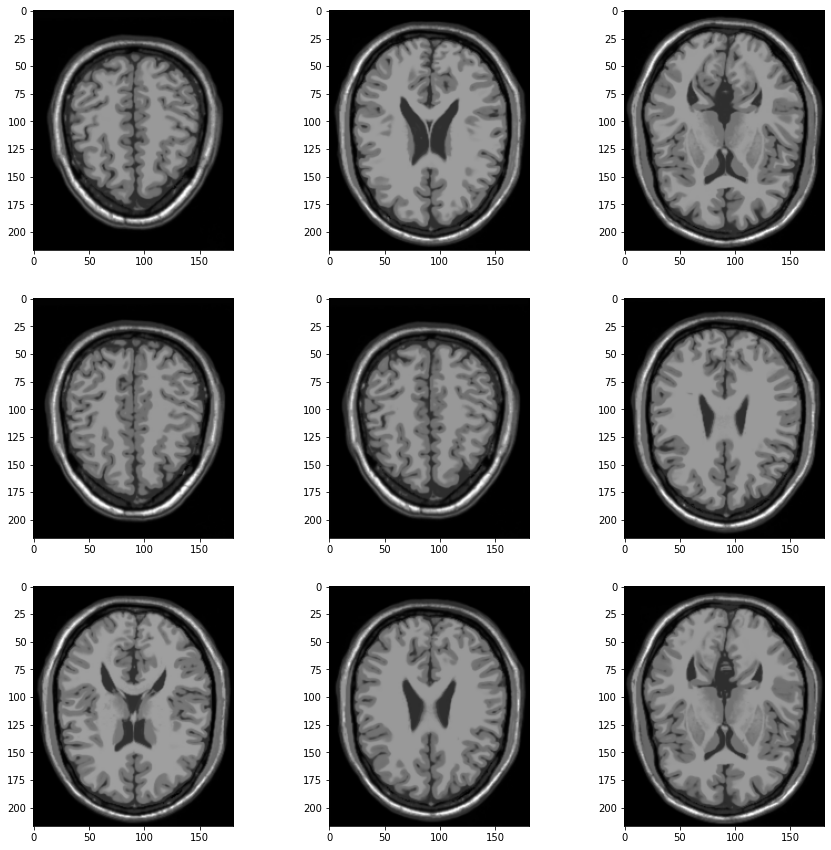

In [19]:
# visualizing data for T1 dataset after normalization

plt.figure(figsize=(15,15))
  
print("TR1 IMAGE")

for images_2 in normalize_t1.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((images_2[i]*127.5+127.5).numpy().astype('uint8'))



In [20]:
normalize_t2 = t2_image.map(lambda x: (normalization_layer(x)))

image_batch_2 = next(iter(normalize_t1))

first_image = image_batch_2[0]

print('After Normalization : ')

print('Minimum : ',np.min(first_image),' Maximum : ',np.max(first_image))

After Normalization : 
Minimum :  -1.0  Maximum :  1.0


In [21]:
image_t2_batch = next(iter(normalize_t2))

image_t2_batch.shape

TensorShape([32, 217, 181, 3])

TR2 IMAGE


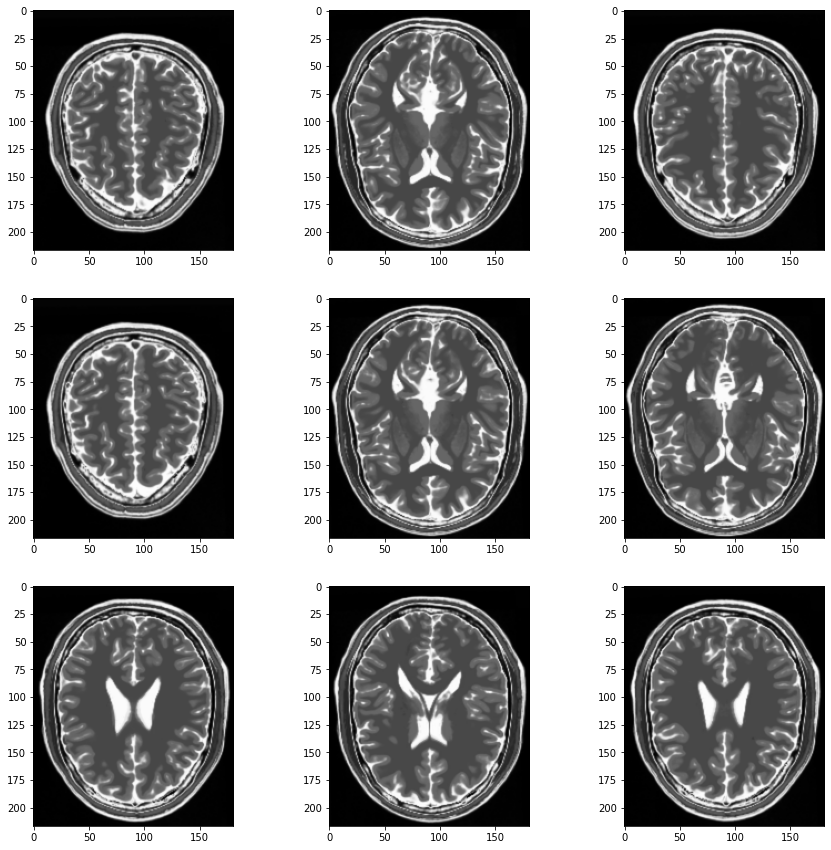

In [22]:
plt.figure(figsize=(15,15))
  
print("TR2 IMAGE")

for images_3 in normalize_t2.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((images_3[i]*127.5+127.5).numpy().astype('uint8'))

In [23]:
# Resizing data to (128,128)

mr1_resize_layer = layers.experimental.preprocessing.Resizing(128,128,interpolation = 'bilinear')

In [24]:
image_t1_resized = normalize_t1.map(lambda x:(mr1_resize_layer(x)))

image_batch_3 = next(iter(image_t1_resized))

first_image = image_batch_3[0]

print('After resizing : ',first_image.shape)

After resizing :  (128, 128, 3)


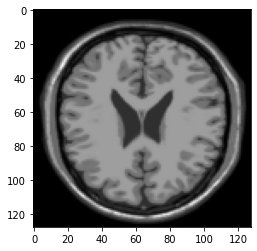

In [25]:
# plotting image for tr1

plt.imshow((first_image*127.5+127.5).numpy().astype('uint8'))

plt.show()

In [26]:
# for tr2

image_t2_resized = normalize_t2.map(lambda x:(mr1_resize_layer(x)))

image_batch_4 = next(iter(image_t2_resized))

first_image = image_batch_4[0]

print('After resizing : ',first_image.shape)

After resizing :  (128, 128, 3)


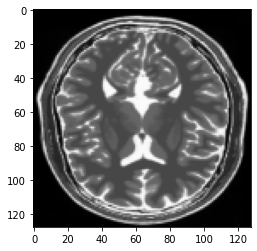

In [27]:
plt.imshow((first_image*127.5+127.5).numpy().astype('uint8'))

plt.show()

In [28]:
# Reshaping the image

mr1_reshape_layer = layers.Reshape((128,128,1))

In [29]:
image_t1_reshape = image_t1_resized.map(lambda x: mr1_reshape_layer(x[:,:,:,0]))

image_batch_5 = next(iter(image_t1_reshape))
print(image_batch_5.shape)
first_image = image_batch_5[0]
print('Shape of reshaped images: ',first_image.shape)

(32, 128, 128, 1)
Shape of reshaped images:  (128, 128, 1)


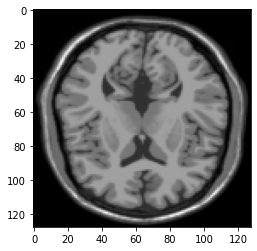

In [30]:
plt.imshow(first_image.numpy()[:,:,0], cmap = 'gray')

plt.show()

In [31]:
# for t2

image_t2_reshape = image_t2_resized.map(lambda x: mr1_reshape_layer(x[:,:,:,0]))

image_batch_6 = next(iter(image_t2_reshape))
print(image_batch_6.shape)
first_image = image_batch_6[0]
print('Shape of reshaped images: ',first_image.shape)



(32, 128, 128, 1)
Shape of reshaped images:  (128, 128, 1)


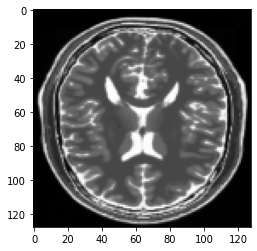

In [32]:
plt.imshow(first_image.numpy()[:,:,0], cmap = 'gray')

plt.show()

### Batch and Reshuffle Data

In [33]:
#setting buffer size

mr1_buffer_size = 32

In [34]:
t1_image_data = image_t1_reshape.shuffle(mr1_buffer_size)

t2_image_data = image_t2_reshape.shuffle(mr1_buffer_size)

In [35]:
image_batch_7 = next(iter(t1_image_data))

print("T1 image batch shape : ",image_batch_7.shape)

first_image = image_batch_7[0]

print('shape of image : ',first_image.shape)



T1 image batch shape :  (11, 128, 128, 1)
shape of image :  (128, 128, 1)


T1 image sample after reshuffle


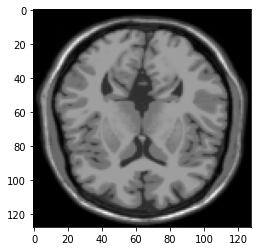

In [36]:
plt.imshow(first_image.numpy()[:,:,0], cmap = 'gray')

print('T1 image sample after reshuffle')

plt.show()

In [37]:
image_batch_8 = next(iter(t2_image_data))

print("T1 image batch shape : ",image_batch_8.shape)

first_image = image_batch_8[0]

print('shape of image : ',first_image.shape)



T1 image batch shape :  (32, 128, 128, 1)
shape of image :  (128, 128, 1)


T2 image sample after reshuffle


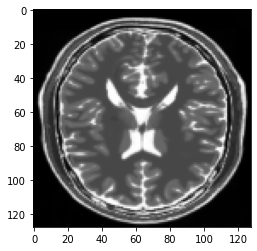

In [38]:
plt.imshow(first_image.numpy()[:,:,0], cmap = 'gray')

print('T2 image sample after reshuffle')

plt.show()

## Step 3 : Model Building

The architecture of generator is a modified U-Net.

1.Create your Generator & Discriminator

2.Define the loss functions

3.Create the train_step function

#### Instance Normalization
Instance Normalization are specially used with Style Transfer, where Separate Normalization is performed for each sample we perform channelwise Normalization.

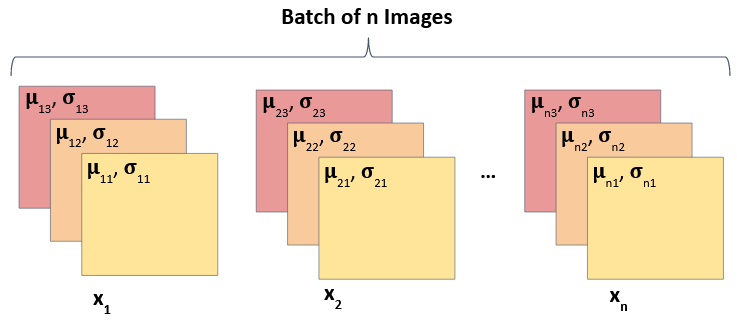

In [39]:
class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon
    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)
    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

#### Downsampling

In [40]:
def downsample(filters, size, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    if apply_norm:
        result.add(InstanceNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result

#### Upsampling

In [41]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                               kernel_initializer=initializer, use_bias=False))
    result.add(InstanceNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

### U net Generator



In [42]:
def unet_generator():
    down_stack = [
        downsample(64, 4, True), 
        downsample(64, 4), 
        downsample(128, 4), 
        downsample(128, 4), 
        downsample(256, 4), 
        downsample(256, 4),
        downsample(512, 4) 
    ]
    up_stack = [
        upsample(256, 4, True), # (bs, 2, 2, 256)
        upsample(256, 4), # (bs, 4, 4, 256)
        upsample(128, 4),
        upsample(128, 4), 
        upsample(64, 4),
        upsample(64, 4) 
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(1, 4, strides=2, padding='same', kernel_initializer=initializer,
                                           activation='tanh') # (bs, 32, 32, 1)
    concat = tf.keras.layers.Concatenate()
    inputs = tf.keras.layers.Input(shape=[128, 128, 1])
    x = inputs
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    
    skips = reversed(skips[:-1])
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

In [43]:
t1_generator = unet_generator()

t2_generator = unet_generator()

In [44]:
t1_generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 64, 64, 64)   1152        ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 32, 32, 64)   65664       ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 16, 16, 128)  131328      ['sequential_1[0][0]']       

In [45]:
t2_generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential_13 (Sequential)     (None, 64, 64, 64)   1152        ['input_2[0][0]']                
                                                                                                  
 sequential_14 (Sequential)     (None, 32, 32, 64)   65664       ['sequential_13[0][0]']          
                                                                                                  
 sequential_15 (Sequential)     (None, 16, 16, 128)  131328      ['sequential_14[0][0]']    

T1 Generator Model


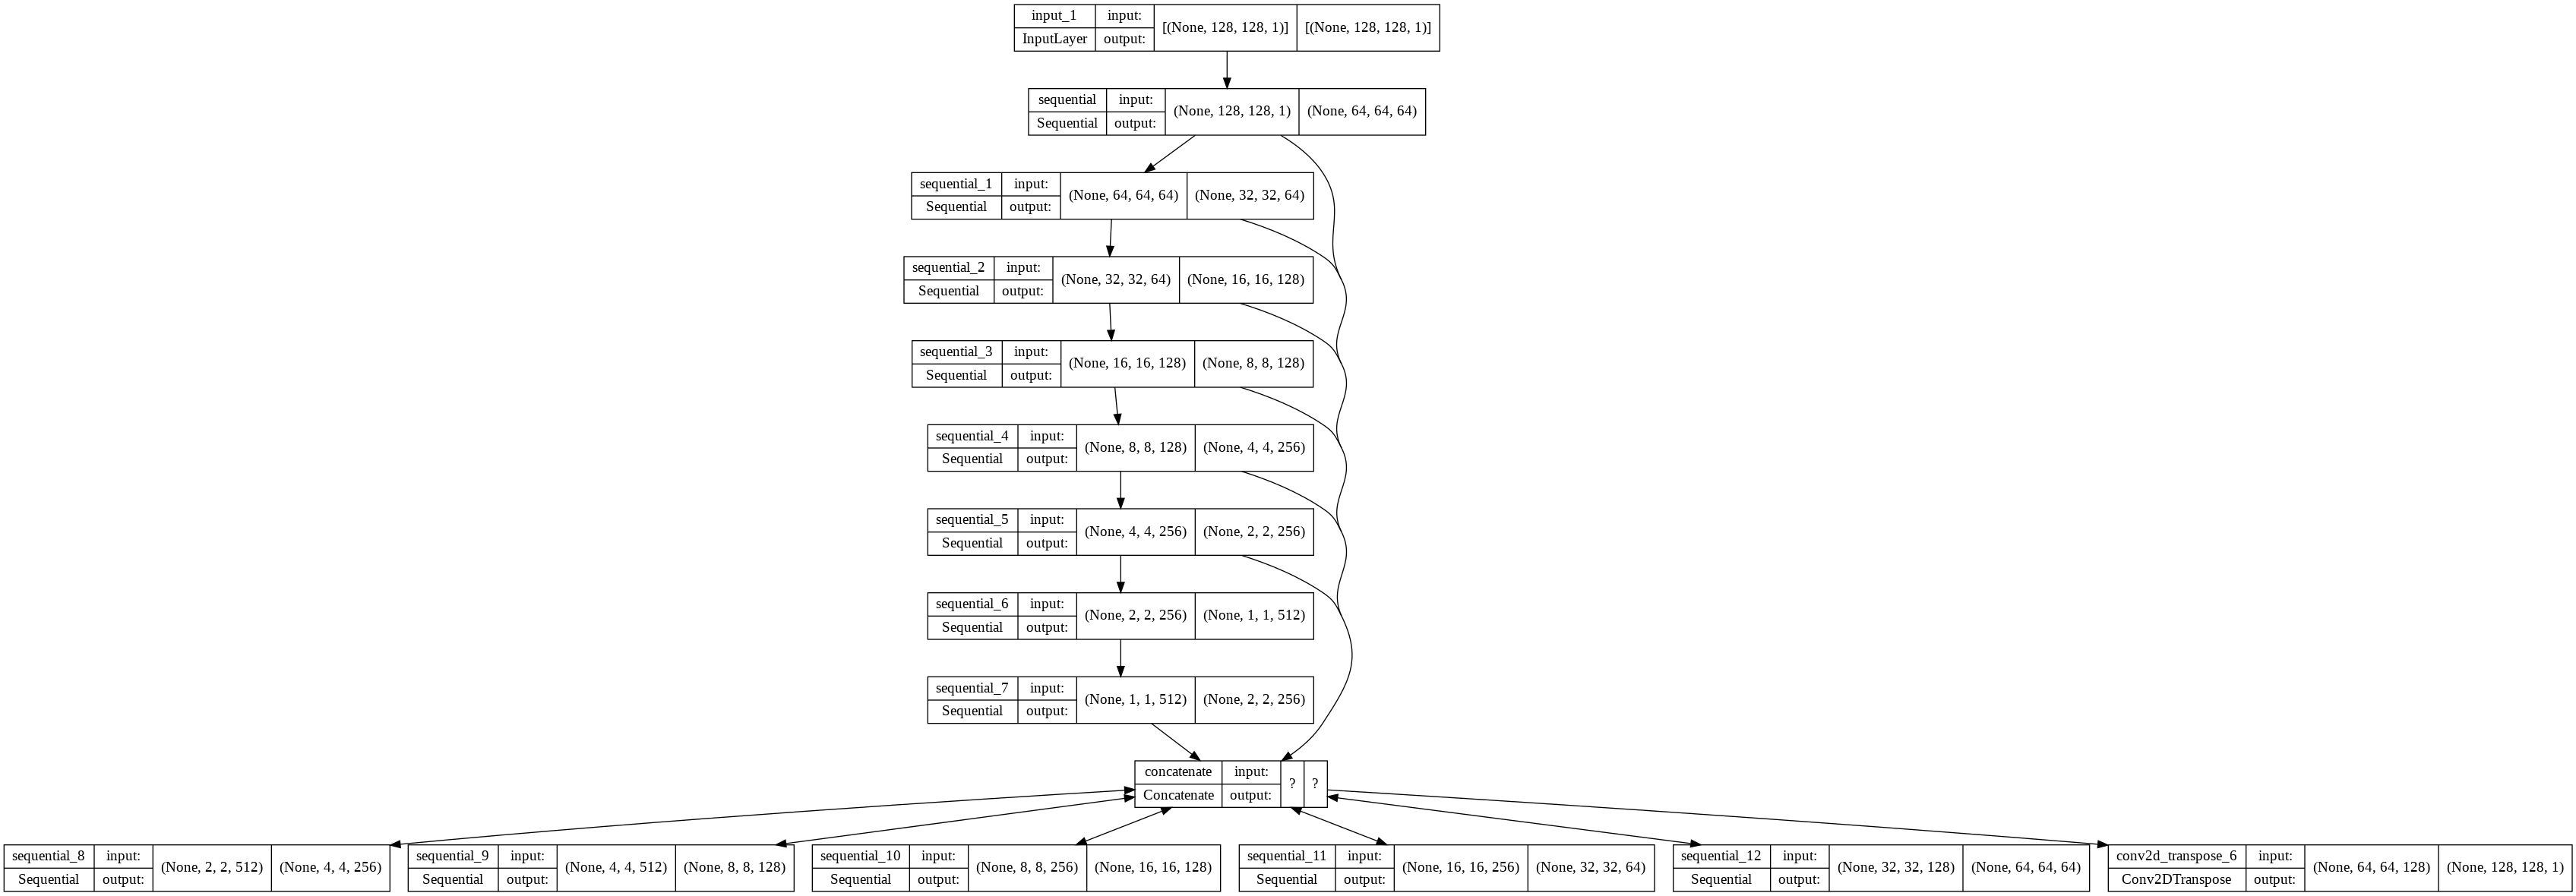

<Figure size 1800x1800 with 0 Axes>

In [46]:
print('T1 Generator Model') 

plt.figure(figsize=(25,25))

plot_model(t1_generator,show_shapes = True,show_layer_names = True)

T2 Generator Model


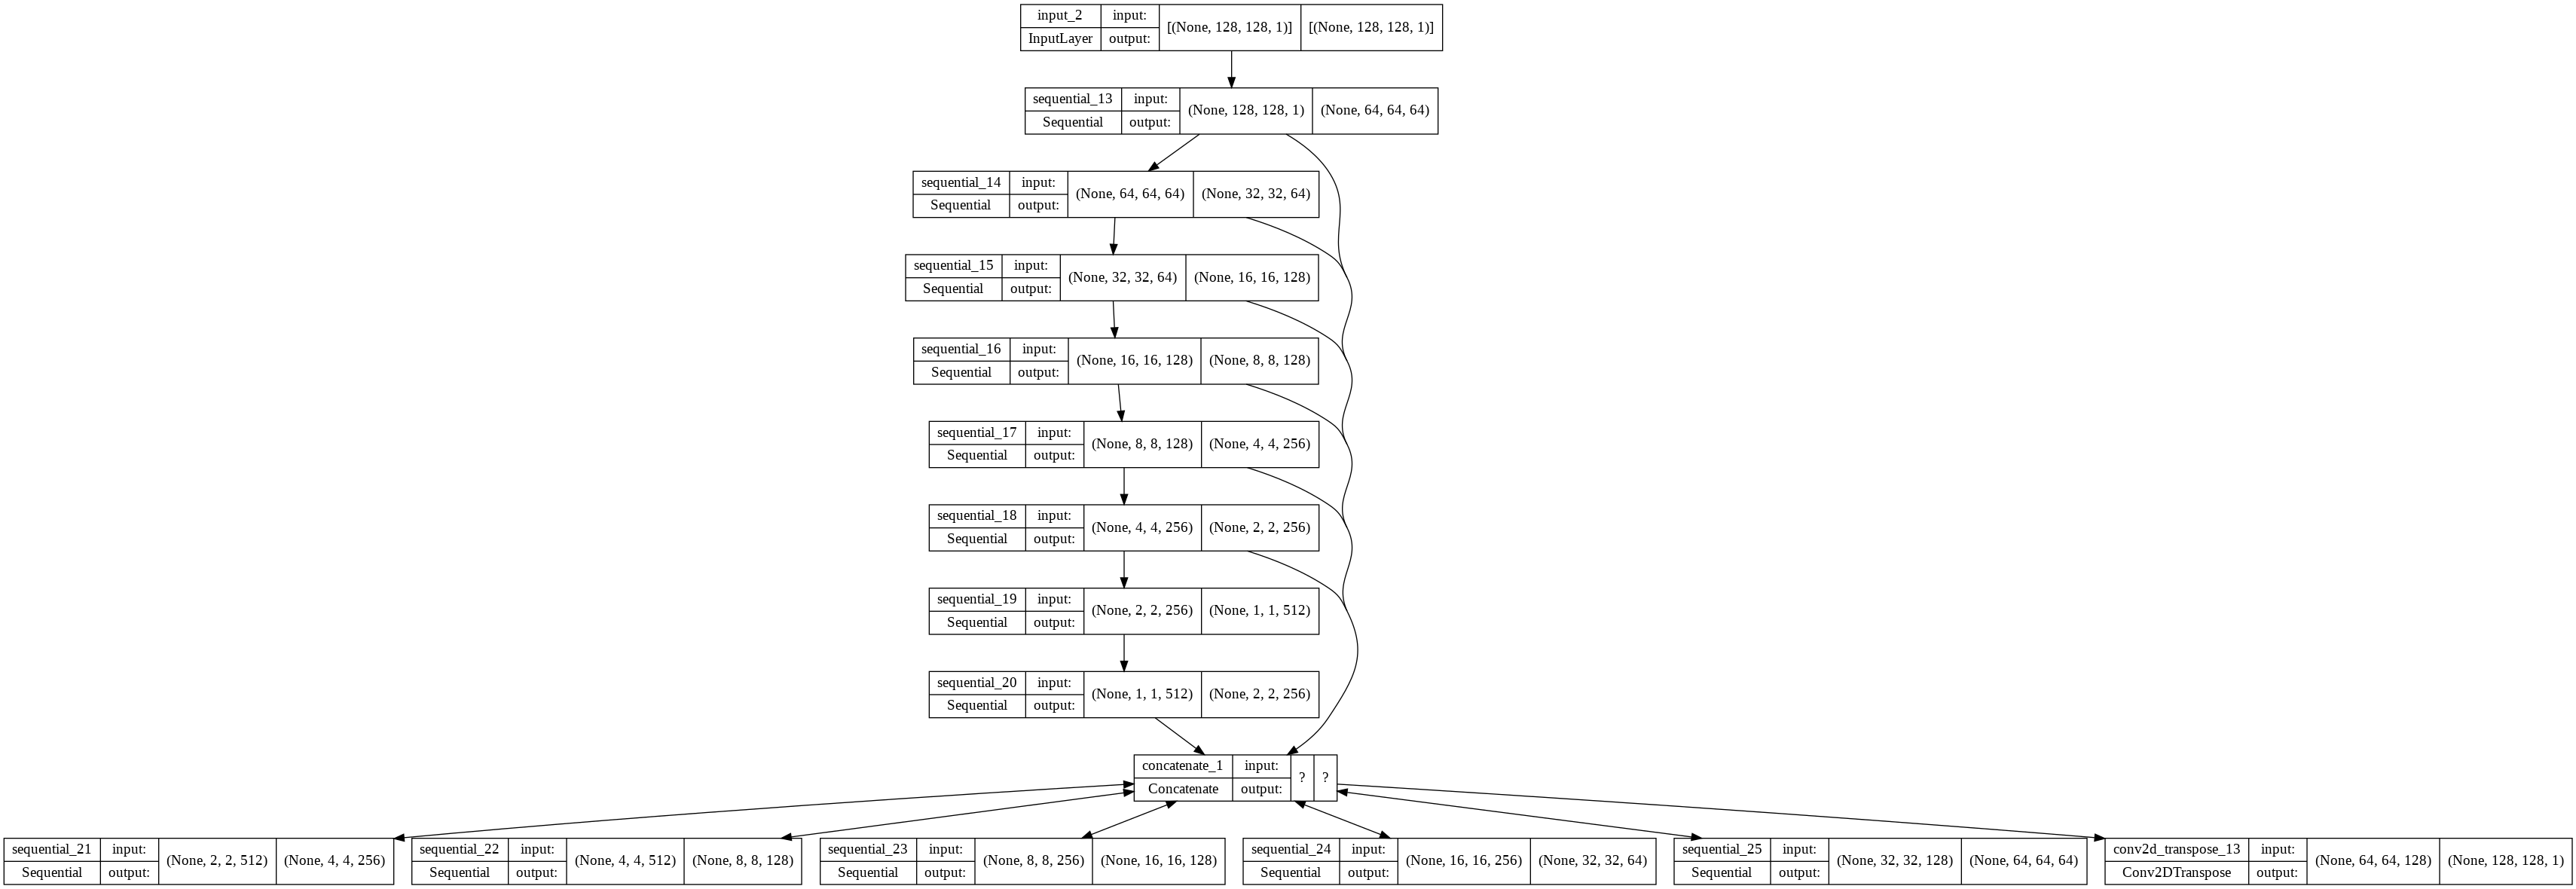

<Figure size 1800x1800 with 0 Axes>

In [47]:
print('T2 Generator Model')

plt.figure(figsize=(25,25))

plot_model(t2_generator,show_shapes=True,show_layer_names=True)

### Discriminator

In [48]:
def discriminator():
  initializer = tf.random_normal_initializer(0.,0.02)
  inp = tf.keras.layers.Input(shape = [128,128,1],name='input_image')
  X = inp

  #downsampling
  down1 = downsample(64,4,False)(X)
  down2 = downsample(128,4)(down1)
  down3 = downsample(256,4)(down2)
  down4 = downsample(512,4)(down3)

  #zero-padding layer

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down4)

  # implement a concrete downsampling layer here

  conv = tf.keras.layers.Conv2D(256,4,strides = 1,kernel_initializer = initializer,
                                use_bias = False)(zero_pad1)
  
  norm1 = InstanceNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(norm1)

  # adding another zero padding layer

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)

  # pure convolution layer

  last = tf.keras.layers.Conv2D(1,4,strides=1,kernel_initializer=initializer)(zero_pad2)

  return tf.keras.Model(inputs = inp,outputs = last)

In [49]:
# defining discriminator

# for T1 images
discriminator_t1 = discriminator()

# for T2 images

discriminator_t2 = discriminator()



In [50]:
# summary for T1 Discriminator

discriminator_t1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 128, 128, 1)]     0         
                                                                 
 sequential_26 (Sequential)  (None, 64, 64, 64)        1024      
                                                                 
 sequential_27 (Sequential)  (None, 32, 32, 128)       131328    
                                                                 
 sequential_28 (Sequential)  (None, 16, 16, 256)       524800    
                                                                 
 sequential_29 (Sequential)  (None, 8, 8, 512)         2098176   
                                                                 
 zero_padding2d (ZeroPadding  (None, 10, 10, 512)      0         
 2D)                                                             
                                                           

In [51]:
# summary for T2 Discriminator

discriminator_t2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 128, 128, 1)]     0         
                                                                 
 sequential_30 (Sequential)  (None, 64, 64, 64)        1024      
                                                                 
 sequential_31 (Sequential)  (None, 32, 32, 128)       131328    
                                                                 
 sequential_32 (Sequential)  (None, 16, 16, 256)       524800    
                                                                 
 sequential_33 (Sequential)  (None, 8, 8, 512)         2098176   
                                                                 
 zero_padding2d_2 (ZeroPaddi  (None, 10, 10, 512)      0         
 ng2D)                                                           
                                                           

T1 Discriminator Model


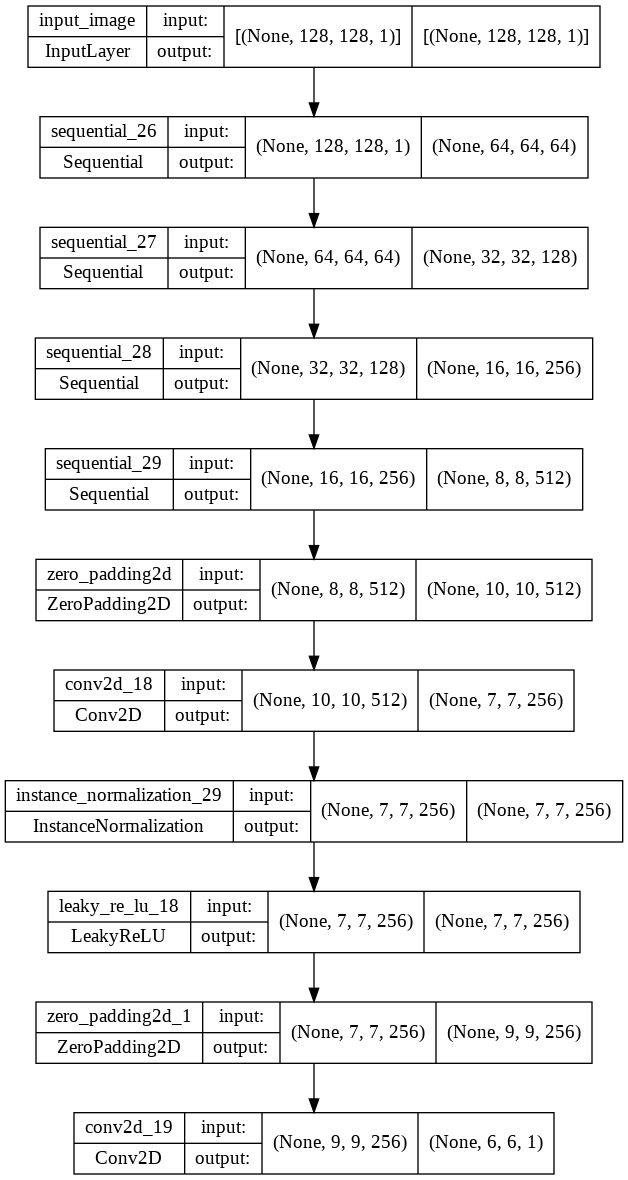

<Figure size 1800x1800 with 0 Axes>

In [52]:
print('T1 Discriminator Model') 

plt.figure(figsize=(25,25))

plot_model(discriminator_t1,show_shapes = True,show_layer_names = True)

T2 Discriminator Model


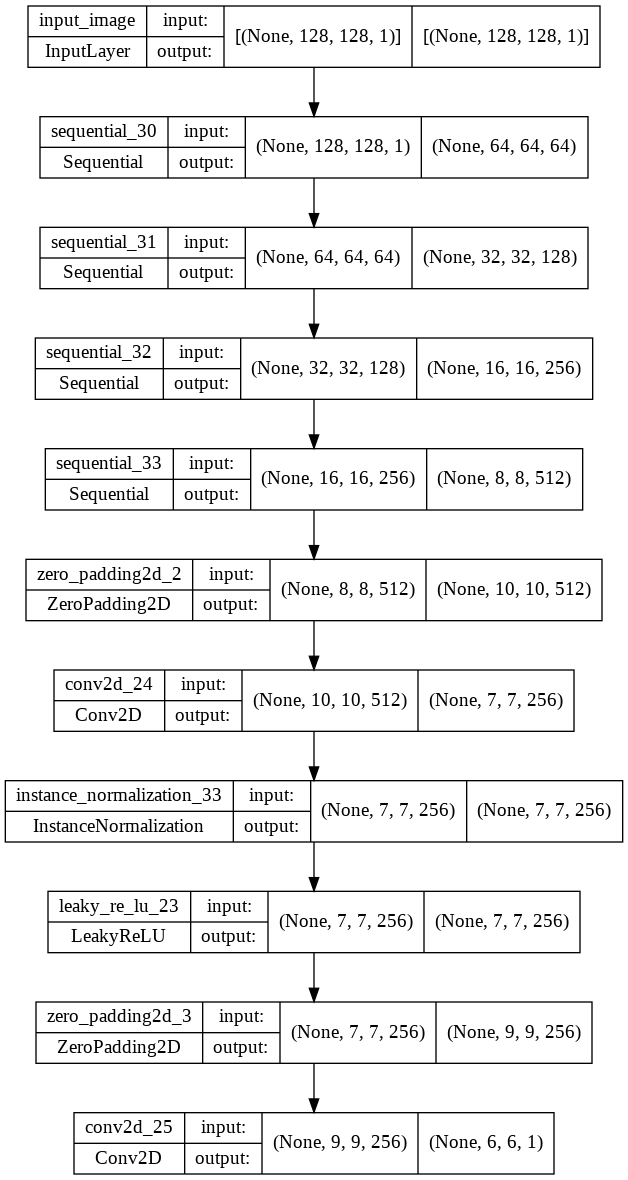

In [53]:
print('T2 Discriminator Model') 

plot_model(discriminator_t2,show_shapes = True,show_layer_names = True)

## Step 4 : Model Training

This are the below steps which will follow in Model Training :
1. Declare Loss type
2. Calculate Discriminator Loss
3. Calculate Generator Loss
4. Cycle Loss
5. Identity Loss
6. Optimizer
7. Checkpoint Initialization
8. Training Flow

### Checking Output of Untrained Generator

In [55]:
# checking sample

t1_sample = next(iter(t1_image_data))

t2_sample = next(iter(t2_image_data))


In [56]:
to_t2 = t2_generator(t1_sample)

to_t1 = t2_generator(t2_sample)

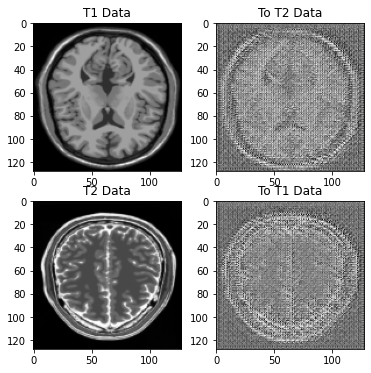

In [61]:
#plotting graph

plt.figure(figsize=(6,6))
contrast = 7

mr1_image = [t1_sample,to_t2,t2_sample,to_t1]
mr1_title = ['T1 Data','To T2 Data','T2 Data','To T1 Data']

for i in range(len(mr1_image)):
  plt.subplot(2,2,i+1)
  plt.title(mr1_title[i])
  if i % 2 == 0:
        plt.imshow(mr1_image[i][0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')
  else:
        plt.imshow(mr1_image[i][0].numpy()[:, :, 0] * 0.5 * contrast + 0.5, cmap='gray')

plt.show()

### Declaing Loss as Binary Cross Entropy



In [62]:
# declaring lambda

mr1_lambda = 10

In [63]:
# Declaring loss object

loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits = True)

### Discriminator Loss


> There are 2 types of losses
1. Loss on Real Data 
2. Loss on Fake Data


In [64]:
def discrimator_loss(real,generated):
  real_loss = loss_obj(tf.ones_like(real),real)
  generated_loss = loss_obj(tf.ones_like(generated),generated)

  # checking total discriminator loss
  total_disc_loss = real_loss + generated_loss

  #taking mean of losses
  return total_disc_loss * 0.5

### Generator Loss

> It has only one type of loss - Discriminator Loss on Generated data



In [65]:
def generator_loss(generated):
  gen_loss = loss_obj(tf.ones_like(generated),generated)
  return gen_loss

### Cyclic Loss

In [66]:
def cyclic_loss(real_image,cyclic_image):
  cyc_loss = tf.reduce_mean(tf.abs(real_image - cyclic_image))
  return mr1_lambda * cyc_loss

### Identity Loss

In [67]:
def identity_loss(real_image,same_image):
  id_loss = tf.reduce_mean(real_image - same_image)
  return mr1_lambda * id_loss

### Optimizer

> We are using Optimizer to update Weights which is a good optimizer to achieve quick learning



